In [0]:
!pip install sentencepiece
!pip install segtok

    100% |████████████████████████████████| 1.0MB 19.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
Successfully built segtok


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sentencepiece as spm
import tensorflow as tf
import numpy as np
import os, sys
import json
import matplotlib.pyplot as plt
import pandas as pd
import string

sys.path.insert(0, "/content/gdrive/My Drive/Project-Lion/") # This enables us to import Python libraries in the folder.

from transformer import Transformer
import capita

root_folder = "/content/gdrive/My Drive/Project-Lion/"

In [0]:
# Load the word piece model that will be used to tokenize the texts into
# word pieces with a vocabulary size of 10000

sp = spm.SentencePieceProcessor()
sp.Load(root_folder+"dataset/wp_vocab10000.model")

vocab = [line.split('\t')[0] for line in open(root_folder+"dataset/wp_vocab10000.vocab", "r")]
pad_index = vocab.index('#')

In [0]:
df = pd.read_csv(root_folder + 'data/kaggle/shortjokes.csv')
df = df.loc[df["Joke"] != ""]

In [0]:
def clean_data(lst, in_place=True, keep_punc=""):
    if in_place:
        new_lst = lst
    else:
        new_lst = lst.copy()
        
    for i in range(len(new_lst)):
        joke = lst[i]
        joke = joke.replace("\r", " ").replace("\n", " ").replace("/", " or ")
        joke = joke.translate(str.maketrans("", "", string.punctuation.replace(keep_punc, ""))) # Remove punctuation
        joke = joke.lower() # Lowercase
        joke = ''.join(char for char in joke if not char.isdigit()) # Remove numbers
        joke = joke.strip() # Remove leading and ending whitespace
        new_lst[i] = joke
    return new_lst

In [0]:
data = clean_data(df["Joke"].tolist(), keep_punc="?")

In [0]:
qa_all = [[s.strip() for s in list(filter(None, joke.split("?")))] for joke in data if len(list(filter(None, joke.split("?")))) == 2]
print("Size of entire dataset:", len(qa_all))
print(qa_all[0])

Size of entire dataset: 93782
['why cant barbie get pregnant', 'because ken comes in a different box heyooooooo']


In [0]:
min_qlen, max_qlen = 3, 15
min_alen, max_alen = 3, 15
qa = [(q, a) for q, a in qa_all if len(q.split()) >= min_qlen and len(q.split()) <= max_qlen and len(a.split()) >= min_alen and len(a.split()) <= max_alen]
print("Size of dataset:", len(qa))
print(qa[0])

Size of dataset: 59999
('why cant barbie get pregnant', 'because ken comes in a different box heyooooooo')


In [0]:
def pad_sequence(numerized, pad_index, to_length):
    pad = numerized[:to_length]
    padded = pad + [pad_index] * (to_length - len(pad))
    mask = [w != pad_index for w in padded]
    return padded, mask

In [0]:
input_length = max_qlen
output_length = max_alen

dataset = []
for q, a in qa:
  d = {}
  # Tokenize, numerize
  d['input'] = sp.EncodeAsIds(capita.preprocess_capitalization(q))
  d['output'] = sp.EncodeAsIds(capita.preprocess_capitalization(a))

  # Padding    
  d['input'], d['input_mask'] =  pad_sequence(d['input'],  pad_index, input_length)
  d['output'], d['output_mask'] = pad_sequence(d['output'], pad_index, output_length)
  dataset.append(d)

In [0]:
dataset_size = len(dataset)
print(dataset_size)

59999


In [0]:
training_size = (dataset_size * 9) // 10

d_train = dataset[:training_size]
d_valid = dataset[training_size:]

len(d_train), len(d_valid)

(53999, 6000)

In [0]:
def build_batch(dataset, batch_size):
    indices = list(np.random.randint(0, len(dataset), size=batch_size))
    
    batch = [dataset[i] for i in indices]
    batch_input = np.array([a['input'] for a in batch])
    batch_input_mask = np.array([a['input_mask'] for a in batch])
    batch_output = np.array([a['output'] for a in batch])
    batch_output_mask = np.array([a['output_mask'] for a in batch])
    
    return batch_input, batch_input_mask, batch_output, batch_output_mask

In [0]:
# We are giving you the trainer, as it is similar to the one
# you created in the Language Modeling assignment.

class TransformerTrainer():

    def __init__(self, vocab_size, d_model, input_length, output_length, n_layers, d_filter, learning_rate=1e-3):

        self.source_sequence = tf.placeholder(tf.int32,shape=(None,input_length), name="source_sequence")
        self.target_sequence = tf.placeholder(tf.int32, shape=(None,output_length),name="target_sequence")
        self.encoder_mask = tf.placeholder(tf.bool,shape=(None,input_length),name="encoder_mask")
        self.decoder_mask = tf.placeholder(tf.bool, shape=(None,output_length),name="decoder_mask")

        self.model = Transformer(vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, d_filter=d_filter)

        self.decoded_logits = self.model(self.source_sequence, self.target_sequence, encoder_mask=self.encoder_mask, decoder_mask=self.decoder_mask)
        self.global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(learning_rate, self.global_step, 100000, 0.96)
        
        # Summarization loss
        self.loss = tf.losses.sparse_softmax_cross_entropy(self.target_sequence, self.decoded_logits, tf.cast(self.decoder_mask, tf.float32))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.98, epsilon=1e-9)
        self.train_op = self.optimizer.minimize(self.loss, global_step=self.global_step)
        self.saver = tf.train.Saver()

In [0]:
def predict(model, model_file, questions=[], size=10, start_idx=None):
  
  sample = questions == []
  if sample:
    if start_idx == None:
      start_idx = np.random.randint(training_size, len(qa) - size)
    questions = [q for q, a in qa[start_idx:start_idx + size]]
    answers = [a for q, a in qa[start_idx:start_idx + size]]

  with tf.Session() as sess:

    model.saver.restore(sess, model_file)
    
    if sample:
      print("\nJokes starting from index:", start_idx)

    for i in range(len(questions)):
      question = questions[i]

      # Process the capitalization with the preprocess_capitalization of the capita package.
      question = capita.preprocess_capitalization(question)

      # Numerize the tokens of the processed text using the loaded sentencepiece model.
      numerized = sp.EncodeAsIds(question)
      # Pad the sequence and keep the mask of the input
      padded, mask = pad_sequence(numerized, pad_index, input_len)

      # Making the news article into a batch of size one, to be fed to the neural network.
      encoder_input = np.array([padded])
      encoder_mask = np.array([mask])

      decoded_so_far = [0]

      for j in range(output_len):
        padded_decoder_input, decoder_mask = pad_sequence(decoded_so_far, pad_index, output_len)
        padded_decoder_input = [padded_decoder_input]
        decoder_mask = [decoder_mask]
        #print("========================")
        #print(padded_decoder_input)
        # Use the model to find the distrbution over the vocabulary for the next word
        logits = sess.run(model.decoded_logits, feed_dict={model.source_sequence: encoder_input, model.encoder_mask: encoder_mask, model.target_sequence: padded_decoder_input, model.decoder_mask: decoder_mask})

        chosen_words = np.argmax(logits, axis=2) # Take the argmax, getting the most likely next word
        decoded_so_far.append(int(chosen_words[0, j])) # We add it to the summary so far

      print("\n=================================================\n")
      print("Question:", question)
      if sample:
        answer = answers[i]
        print("Answer:", answer)
      print("Predicted answer:", "".join([vocab[i] for i in decoded_so_far]).replace("▁", " "))

# Initialize new model

In [0]:
# Dataset related parameters
vocab_size = len(vocab)
input_len = max_qlen # Length of the article
output_len = max_alen # Length of the summaries

# Model related parameters, feel free to modify these.
n_layers = 6
d_model  = 256
d_filter = 416

tf.reset_default_graph()
model = TransformerTrainer(vocab_size, d_model, input_len, output_len, n_layers, d_filter, learning_rate=1e-3)

# Initial Training

In [0]:
model_file = root_folder+"models/transformer_model"

batch_size = 50
epochs = 10

iter_per_epoch = len(d_train) // batch_size
total_iterations = iter_per_epoch * epochs
print_per_iter = 10
eval_per_iter = 50
save_per_iter = 100

print("Total iterations:", total_iterations)

train_losses = []
val_losses = []
iterations = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for epoch in range(1, epochs + 1):
        print("Epoch:", epoch)
        for _ in range(iter_per_epoch):
            batch_input, batch_input_mask, batch_output, batch_output_mask = build_batch(d_train, batch_size)
            feed = {model.source_sequence: batch_input, model.target_sequence: batch_output,
                              model.encoder_mask: batch_input_mask, model.decoder_mask: batch_output_mask}

            train_loss, _, step = sess.run([model.loss, model.train_op, model.global_step], feed_dict=feed)

            if iteration % print_per_iter == 0:
                print("Iteration {0} / {1}: Training loss - {2}".format(iteration, total_iterations, train_loss))

            if iteration % eval_per_iter == 0:
                batch_input, batch_input_mask, batch_output, batch_output_mask = build_batch(d_valid, batch_size)
                feed = {model.source_sequence: batch_input, model.target_sequence: batch_output,
                              model.encoder_mask: batch_input_mask, model.decoder_mask: batch_output_mask}
                eval_loss = sess.run(model.loss, feed_dict=feed)
                print("Evaluation loss:", eval_loss)
                val_losses.append(eval_loss)
                train_losses.append(train_loss)
                iterations.append(iteration)
                
            if iteration % save_per_iter == 0:
                model.saver.save(sess, model_file)
                np.save(root_folder + "models/transformer_model_train_losses", np.array(train_losses))
                np.save(root_folder + "models/transformer_model_val_losses", np.array(val_losses))
                np.save(root_folder + "models/transformer_model_iterations", np.array(iterations))
                
            iteration += 1

Total iterations: 10790
Epoch: 1
Iteration 10 / 10790: Training loss - 9.302825927734375
Iteration 20 / 10790: Training loss - 8.529587745666504
Iteration 30 / 10790: Training loss - 8.6222562789917
Iteration 40 / 10790: Training loss - 8.441946029663086
Iteration 50 / 10790: Training loss - 8.565862655639648
Evaluation loss: 8.226765
Iteration 60 / 10790: Training loss - 8.36087703704834
Iteration 70 / 10790: Training loss - 8.175726890563965
Iteration 80 / 10790: Training loss - 8.144606590270996
Iteration 90 / 10790: Training loss - 8.354171752929688
Iteration 100 / 10790: Training loss - 8.107654571533203
Evaluation loss: 8.264207
Iteration 110 / 10790: Training loss - 8.176652908325195
Iteration 120 / 10790: Training loss - 7.914579391479492
Iteration 130 / 10790: Training loss - 8.302800178527832
Iteration 140 / 10790: Training loss - 8.044289588928223
Iteration 150 / 10790: Training loss - 7.804849624633789
Evaluation loss: 7.8036613
Iteration 160 / 10790: Training loss - 7.8176

KeyboardInterrupt: ignored

# Continue Training Model

In [0]:
model_file = root_folder + "models/transformer_model"

batch_size = 50
epochs = 10

iter_per_epoch = len(d_train) // batch_size
total_iterations = iter_per_epoch * epochs
print_per_iter = 10
eval_per_iter = 50
save_per_iter = 100

train_losses = np.load(root_folder + "models/transformer_model_train_losses.npy").tolist()
val_losses = np.load(root_folder + "models/transformer_model_val_losses.npy").tolist()
iterations = np.load(root_folder + "models/transformer_model_iterations.npy").tolist()

with tf.Session() as sess:
    model.saver.restore(sess, model_file)
    print("Continue running for", total_iterations, "iterations")
    iteration = iterations[-1] + 1
    total_iterations = iteration + total_iterations - 1
    
    for epoch in range(1, epochs + 1):
        print("Epoch:", epoch)
        for _ in range(iter_per_epoch):
            batch_input, batch_input_mask, batch_output, batch_output_mask = build_batch(d_train, batch_size)
            feed = {model.source_sequence: batch_input, model.target_sequence: batch_output,
                              model.encoder_mask: batch_input_mask, model.decoder_mask: batch_output_mask}

            train_loss, _, step = sess.run([model.loss, model.train_op, model.global_step], feed_dict=feed)

            if iteration % print_per_iter == 0:
                print("Iteration {0} / {1}: Training loss - {2}".format(iteration, total_iterations, train_loss))

            if iteration % eval_per_iter == 0:
                batch_input, batch_input_mask, batch_output, batch_output_mask = build_batch(d_valid, batch_size)
                feed = {model.source_sequence: batch_input, model.target_sequence: batch_output,
                              model.encoder_mask: batch_input_mask, model.decoder_mask: batch_output_mask}
                eval_loss = sess.run(model.loss, feed_dict=feed)
                print("Evaluation loss:", eval_loss)
                val_losses.append(eval_loss)
                train_losses.append(train_loss)
                iterations.append(iteration)
                
            if iteration % save_per_iter == 0:
                model.saver.save(sess, model_file)
                np.save(root_folder + "models/transformer_model_train_losses", np.array(train_losses))
                np.save(root_folder + "models/transformer_model_val_losses", np.array(val_losses))
                np.save(root_folder + "models/transformer_model_iterations", np.array(iterations))
                
            iteration += 1

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Project-Lion/models/transformer_model
Continue running for 10790 iterations
Epoch: 1
Iteration 6610 / 17390: Training loss - 4.230494976043701
Iteration 6620 / 17390: Training loss - 4.12554931640625
Iteration 6630 / 17390: Training loss - 4.20909309387207
Iteration 6640 / 17390: Training loss - 4.141358375549316
Iteration 6650 / 17390: Training loss - 4.076033592224121
Evaluation loss: 4.7744427
Iteration 6660 / 17390: Training loss - 3.572007894515991
Iteration 6670 / 17390: Training loss - 4.504037857055664
Iteration 6680 / 17390: Training loss - 4.499098777770996
Iteration 6690 / 17390: Training loss - 4.149064064025879
Iteration 6700 / 17390: Training loss - 4.52952766418457
Evaluation loss: 4.6322284
Iteration 6710 / 17390: Training loss - 3.8780694007873535
Iteration 6720 / 17390: Training loss - 4.042656898498535
Iteration 6730 / 17390: Training loss - 4.074113368988037
Iteration 6740 / 17390: Training loss - 3.

KeyboardInterrupt: ignored

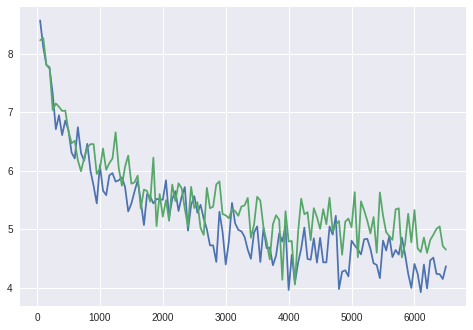

In [0]:
plt.plot(iterations, train_losses)
plt.plot(iterations, val_losses)
plt.show()

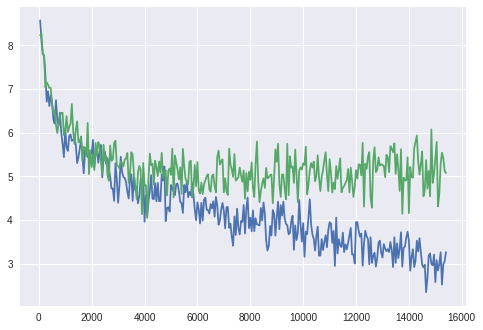

In [0]:
plt.plot(iterations, train_losses)
plt.plot(iterations, val_losses)
plt.show()

# Predict

In [0]:
predict(model, model_file)

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Project-Lion/models/transformer_model

Jokes starting from index: 58690


Question: wonder woman whats the difference between wonder woman and the dickless wonder
Answer: one was played in the s by lynda the other by jimmy
Predicted answer: <unk> i  doncryt when  ice quarterler to to your your


Question: do you want to hear a powerball joke
Answer: sorry odds are you wont get it
Predicted answer: <unk> never never mind fix you it means but are i people takes to him eat


Question: what do you call a deer with big eyes
Answer: a bigeye deer
Predicted answer: <unk> a a  ctyunatning of  imim so a


Question: whats the difference between eating pussy and driving in fog
Answer: when youre eating pussy you can see the asshole in front of you
Predicted answer: <unk> one one ofs them seen is the a other s oneuff reed


Question: what is springy and springy
Answer: the easter bunny
Predicted answer: <unk> a a white white christ

In [0]:
predict(model, model_file, questions=["why did the chicken cross the street"])

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Project-Lion/models/transformer_model


Question: why did the chicken cross the street
Predicted answer: <unk> to to get get to to the the other other side side how how to
